In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline


1. intro
2. micrograd overview
3. derivative of a simple function with one input
4. derivative of a function with multiple inputs
5. starting the core Value object of micrograd and its visualization
6. manual backpropagation example #1: simple expression
7. preview of a single optimization step
8. manual backpropagation example #2: a neuron
9. implementing the backward function for each operation
10. implementing the backward function for a whole expression graph
11. fixing a backprop bug when one node is used multiple times
12. breaking up a tanh, exercising with more operations
13. doing the same thing but in PyTorch: comparison
14. building out a neural net library (multi-layer perceptron) in micrograd
15. creating a tiny dataset, writing the loss function
16. collecting all of the parameters of the neural net
17. doing gradient descent optimization manually, training the network
18. summary of what we learned, how to go towards modern neural nets
19. walkthrough of the full code of micrograd on github
20. real stuff: diving into PyTorch, finding their backward pass for tanh
21. conclusion

## 3. derivative of a simple function with one input

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

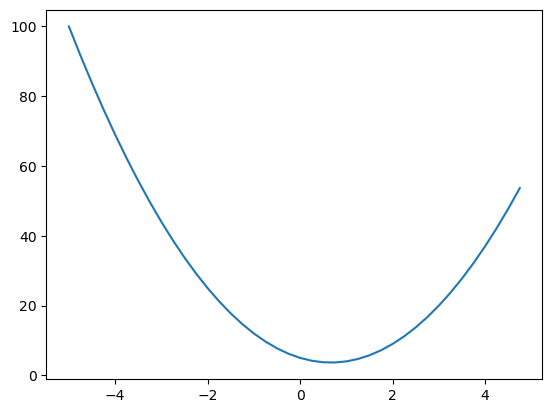

In [10]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

## 4. derivative of a function with multiple inputs

In [11]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [12]:
## lets start the complex topic
a = 2.0
b = -3.0
c = 10.0
d = a*b +c 
print(d)

4.0


In [15]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
c += h
d2 = a*b +c

print("d1:",d1)
print("d2:",d2)
print('slope:',(d2-d1)/h)

d1: 4.0
d2: 4.0009999999999994
slope: 0.9999999999994458


## 5. starting the core Value object of micrograd and its visualization

In [2]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data= {self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),'+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward= _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self_grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data= -8.0)

5. starting the core Value object of micrograd and its visualization

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

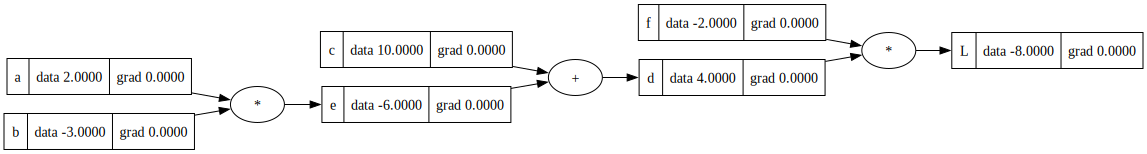

In [4]:
draw_dot(L)